<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

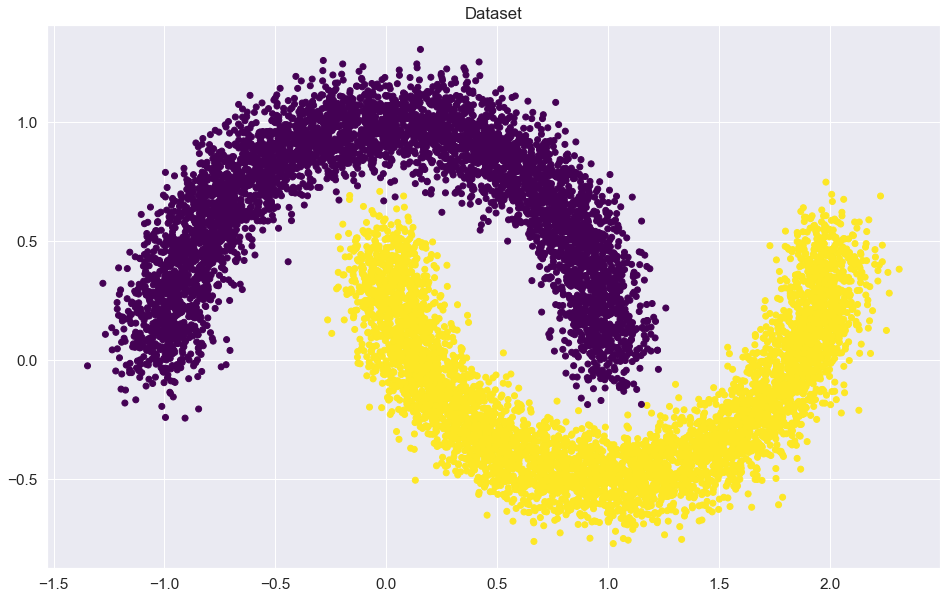

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

In [6]:
# YOUR CODE
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1)) # YOUR CODE

    def forward(self, x):
        x =  torch.matmul(x, self.weights) # YOUR CODE
        if self.bias:
            x += self.bias_term # YOUR CODE
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [10]:
sum(1 for p in linear_regression.parameters())

2

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch) # YOUR CODE
        loss =  loss_function(outp, y_batch.unsqueeze(1)) # YOUR CODE
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.7109375
Iteration: 100
Batch accuracy: 0.78125
Iteration: 200
Batch accuracy: 0.796875
Iteration: 300
Batch accuracy: 0.859375
Iteration: 400
Batch accuracy: 0.8515625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375

Iteration: 696.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 696

### Визуализируем результаты

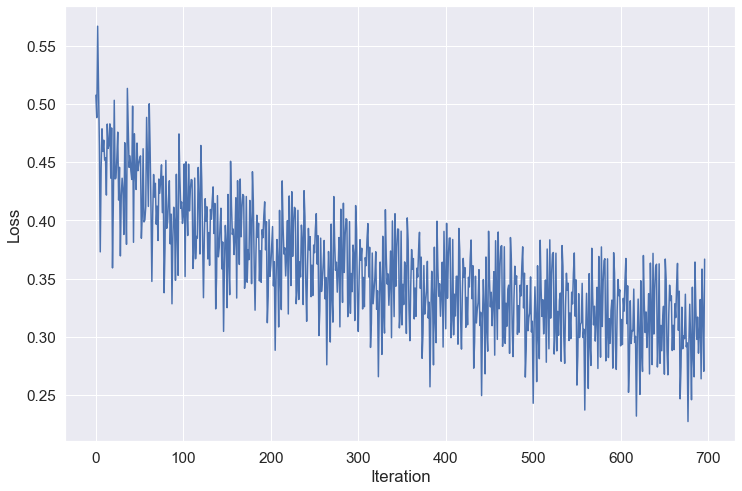

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

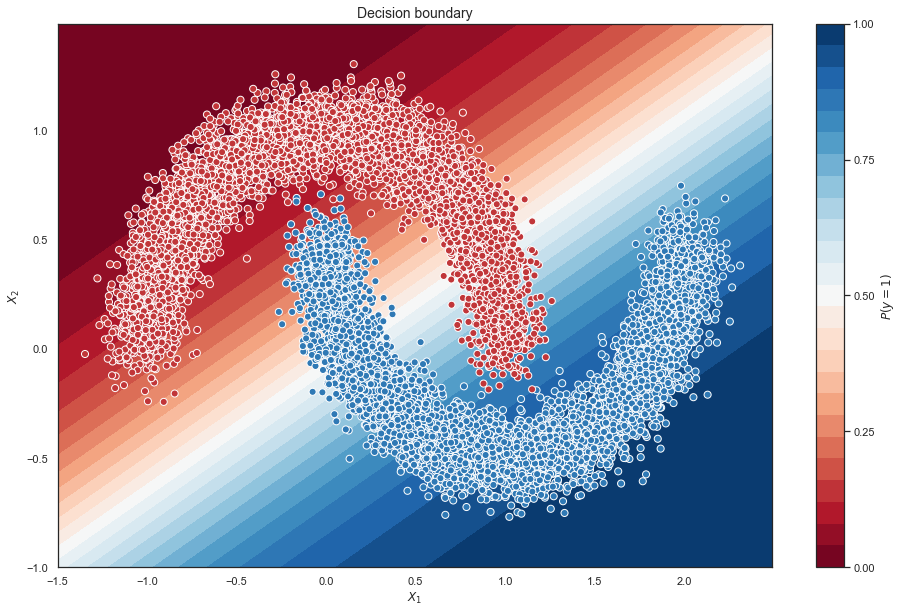

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch) # YOUR CODE
        probs = torch.sigmoid(outp) # YOUR CODE
        preds = (probs > 0.5).type(torch.long) # YOUR CODE
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
predicts = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t, predicts)

0.8556

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8556

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [16]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128) # YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size=128) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [64]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [65]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 10)
)

In [66]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [274]:
def fit(model, optimizer, criterion):    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if k == "train":
                     # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                     # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum() # YOUR CODE GOES HERE
                all = y_batch.size(0) # YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

In [70]:
%%time
accuracy = fit(model, optimizer, criterion)

Epoch: 1
Loader: train. Accuracy: 0.9402166666666667
Loader: valid. Accuracy: 0.9487
Epoch: 2
Loader: train. Accuracy: 0.95655
Loader: valid. Accuracy: 0.9575
Epoch: 3
Loader: train. Accuracy: 0.9659333333333333
Loader: valid. Accuracy: 0.964
Epoch: 4
Loader: train. Accuracy: 0.972
Loader: valid. Accuracy: 0.9671
Epoch: 5
Loader: train. Accuracy: 0.9762333333333333
Loader: valid. Accuracy: 0.9689
Epoch: 6
Loader: train. Accuracy: 0.9803666666666667
Loader: valid. Accuracy: 0.9704
Epoch: 7
Loader: train. Accuracy: 0.9831333333333333
Loader: valid. Accuracy: 0.9708
Epoch: 8
Loader: train. Accuracy: 0.9855166666666667
Loader: valid. Accuracy: 0.9732
Epoch: 9
Loader: train. Accuracy: 0.9876833333333334
Loader: valid. Accuracy: 0.9739
Epoch: 10
Loader: train. Accuracy: 0.9889833333333333
Loader: valid. Accuracy: 0.973
Wall time: 1min 49s


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [71]:
elu_accuracy = accuracy["valid"]

In [72]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation(),
        nn.Linear(128, 10)
    )
    
    optimizer = torch.optim.Adam(model.parameters())
    return fit(model, optimizer, criterion)

In [73]:
%%time
plain_accuracy = test_activation_function(Identical)['valid']

Epoch: 1
Loader: train. Accuracy: 0.8645833333333334
Loader: valid. Accuracy: 0.9034
Epoch: 2
Loader: train. Accuracy: 0.8999666666666667
Loader: valid. Accuracy: 0.9046
Epoch: 3
Loader: train. Accuracy: 0.9054
Loader: valid. Accuracy: 0.907
Epoch: 4
Loader: train. Accuracy: 0.90725
Loader: valid. Accuracy: 0.908
Epoch: 5
Loader: train. Accuracy: 0.9088166666666667
Loader: valid. Accuracy: 0.909
Epoch: 6
Loader: train. Accuracy: 0.9101
Loader: valid. Accuracy: 0.9097
Epoch: 7
Loader: train. Accuracy: 0.9107833333333333
Loader: valid. Accuracy: 0.9095
Epoch: 8
Loader: train. Accuracy: 0.9117833333333333
Loader: valid. Accuracy: 0.9097
Epoch: 9
Loader: train. Accuracy: 0.91255
Loader: valid. Accuracy: 0.9096
Epoch: 10
Loader: train. Accuracy: 0.9135166666666666
Loader: valid. Accuracy: 0.9101
Wall time: 1min 50s


In [74]:
%%time
relu_accuracy = test_activation_function(nn.ReLU)['valid']

Epoch: 1
Loader: train. Accuracy: 0.8684833333333334
Loader: valid. Accuracy: 0.9129
Epoch: 2
Loader: train. Accuracy: 0.92315
Loader: valid. Accuracy: 0.9366
Epoch: 3
Loader: train. Accuracy: 0.9431333333333334
Loader: valid. Accuracy: 0.9488
Epoch: 4
Loader: train. Accuracy: 0.9544666666666667
Loader: valid. Accuracy: 0.9542
Epoch: 5
Loader: train. Accuracy: 0.9623
Loader: valid. Accuracy: 0.957
Epoch: 6
Loader: train. Accuracy: 0.9681833333333333
Loader: valid. Accuracy: 0.9573
Epoch: 7
Loader: train. Accuracy: 0.9723333333333334
Loader: valid. Accuracy: 0.9609
Epoch: 8
Loader: train. Accuracy: 0.9755166666666667
Loader: valid. Accuracy: 0.96
Epoch: 9
Loader: train. Accuracy: 0.97795
Loader: valid. Accuracy: 0.9617
Epoch: 10
Loader: train. Accuracy: 0.9799833333333333
Loader: valid. Accuracy: 0.9619
Wall time: 1min 49s


In [75]:
%%time
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)['valid']

Epoch: 1
Loader: train. Accuracy: 0.8703666666666666
Loader: valid. Accuracy: 0.921
Epoch: 2
Loader: train. Accuracy: 0.92825
Loader: valid. Accuracy: 0.9415
Epoch: 3
Loader: train. Accuracy: 0.9476
Loader: valid. Accuracy: 0.953
Epoch: 4
Loader: train. Accuracy: 0.95825
Loader: valid. Accuracy: 0.9579
Epoch: 5
Loader: train. Accuracy: 0.9659833333333333
Loader: valid. Accuracy: 0.9624
Epoch: 6
Loader: train. Accuracy: 0.9705333333333334
Loader: valid. Accuracy: 0.964
Epoch: 7
Loader: train. Accuracy: 0.9740666666666666
Loader: valid. Accuracy: 0.9645
Epoch: 8
Loader: train. Accuracy: 0.97735
Loader: valid. Accuracy: 0.9636
Epoch: 9
Loader: train. Accuracy: 0.9796166666666667
Loader: valid. Accuracy: 0.9654
Epoch: 10
Loader: train. Accuracy: 0.98155
Loader: valid. Accuracy: 0.9629
Wall time: 1min 50s


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

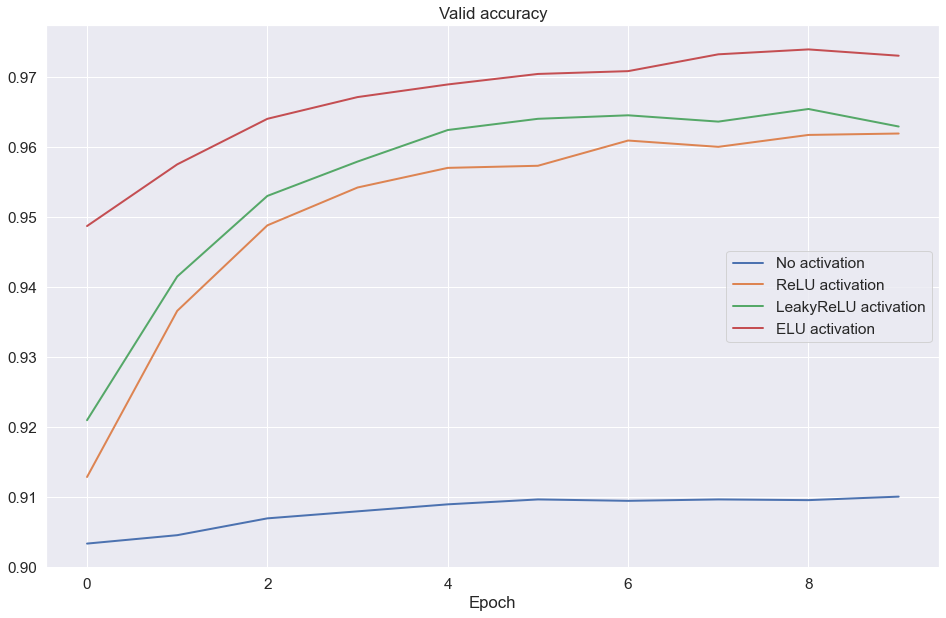

In [76]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

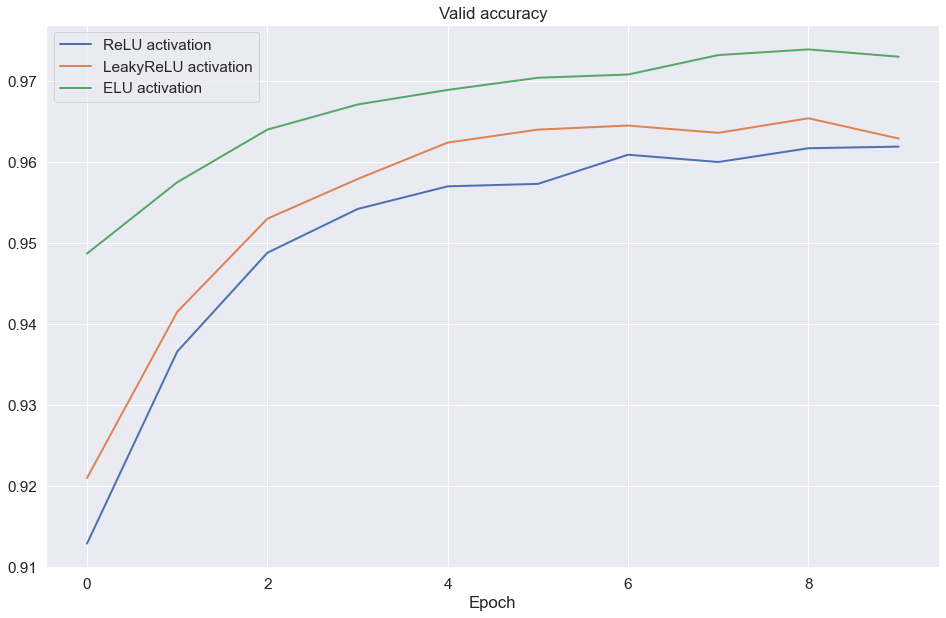

In [77]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU 

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [2]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-11-08 00:41:12--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-11-08 00:41:13--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: 'sample_photo.jpg'

     0K .......... .......... .......... .......... ........  100%  147K=0,3s

2022-11-08 00:41:14 (147 KB/s) - 'sample_photo.jpg' saved [49337/493

In [5]:
# !pip install opencv-python

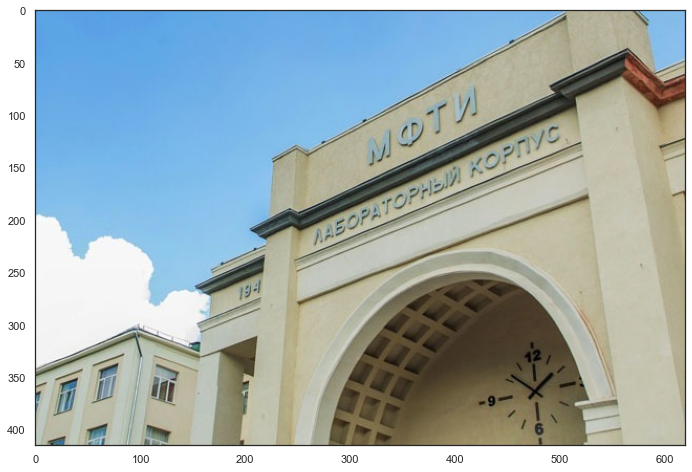

In [6]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [8]:
def plot(matrix):
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor(
        matrix
    ).reshape(1, 1, 3, 3).type(torch.float32)

    kernel = kernel.repeat(3, 3, 1, 1)  # Получаем 3 канала и 3 фильтра исходного размера
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W] заменим оси
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]  #

    plt.figure(figsize=(12, 8))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    plt.imshow(result_np)
    plt.show()

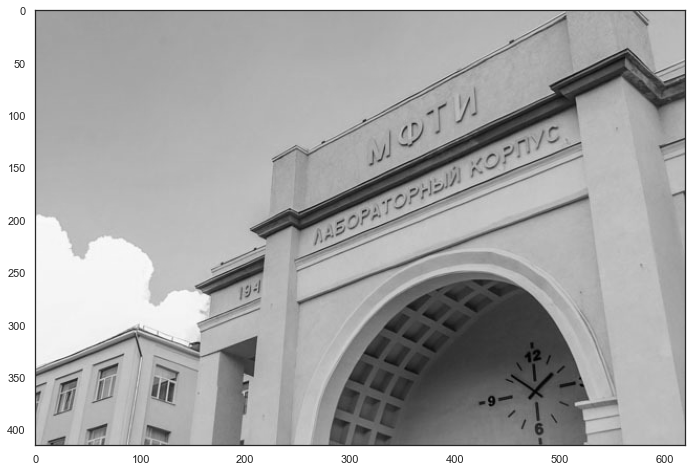

In [10]:
plot([
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


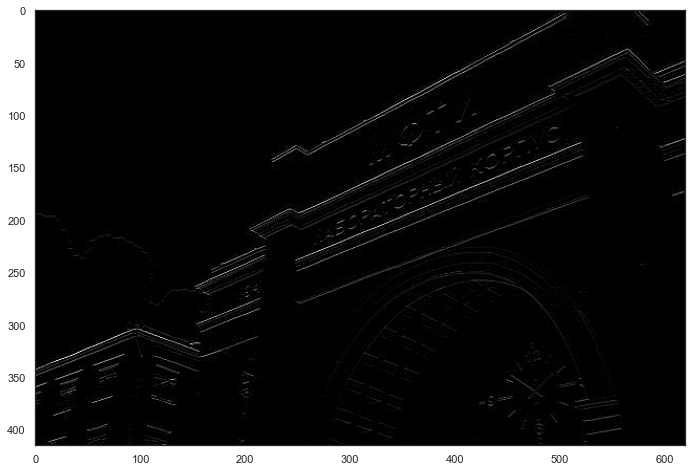

In [11]:
plot([
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


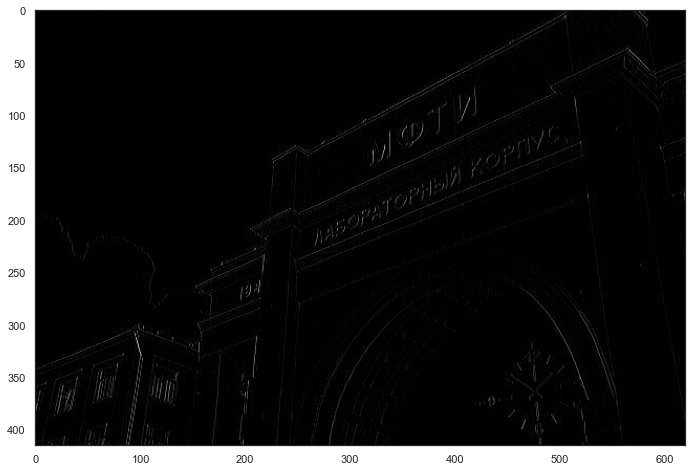

In [12]:
plot([
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


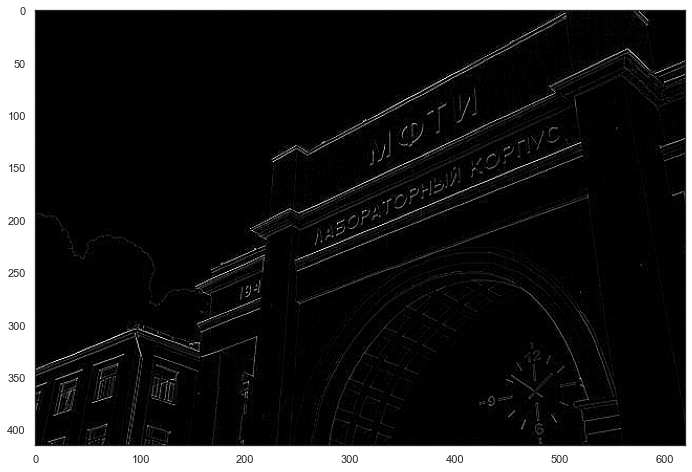

In [13]:
plot([
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


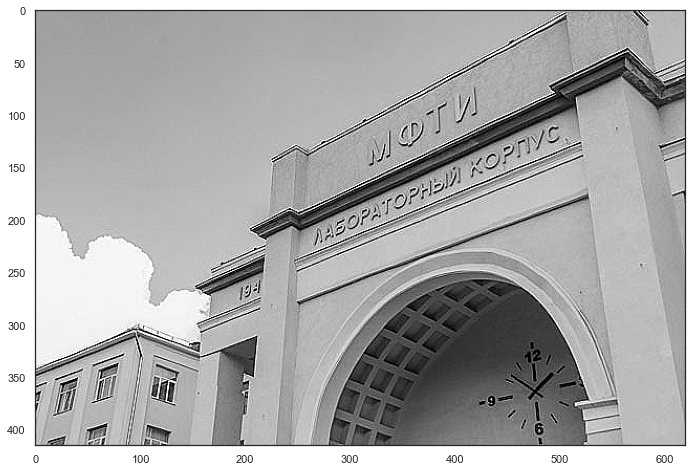

In [14]:
plot([
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
])

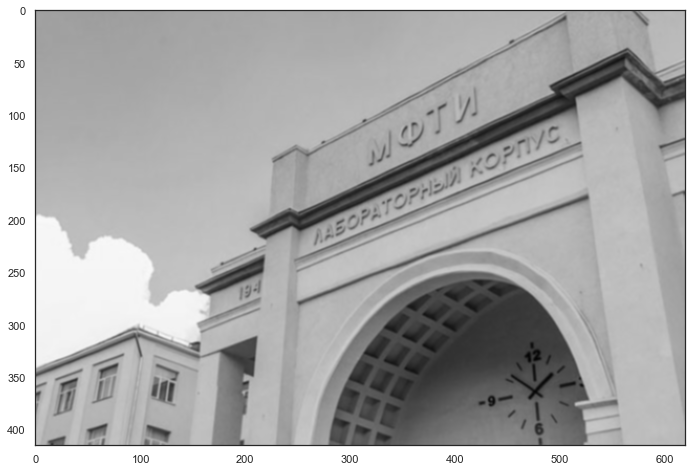

In [15]:
plot([
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
])

In [16]:
# img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
# kernel = torch.tensor([
#     [0, 0, 0],
#     [1, -2, 1],
#     [0, 0, 0]
# ]).reshape(1, 1, 3, 3).type(torch.float32)

# kernel = kernel.repeat(3, 3, 1, 1)  # Получаем 3 канала и 3 фильтра исходного размера
# img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W] заменим оси
# img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

# result = F.conv2d(img_t, kernel)[0]  #

In [17]:
# plt.figure(figsize=(12, 8))
# result_np = result.permute(1, 2, 0).numpy() / 256 / 3

# plt.imshow(result_np)
# plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие (E)

2) Увеличение резкости (Д)

3) Тождественное преобразование (А)

4) Выделение вертикальных границ (В)

5) Выделение горизонтальных границ (Б)

6) Выделение границ (Г)

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [275]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # 6 input channels, 16 output channels 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2) 
        # Fully connected layer with 120 neurons
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        # Fully connected layer with 84 neurons
        self.fc2 = nn.Linear(120, 84)
        # Output layer with 10 neurons
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #YOUR CODE. Apply layers created in __init__. 
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)  #x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [276]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [277]:
accuracy = fit(model, optimizer, criterion)

Epoch: 1
Loader: train. Accuracy: 0.88945
Loader: valid. Accuracy: 0.9692
Epoch: 2
Loader: train. Accuracy: 0.97065
Loader: valid. Accuracy: 0.9768
Epoch: 3
Loader: train. Accuracy: 0.9793
Loader: valid. Accuracy: 0.9833
Epoch: 4
Loader: train. Accuracy: 0.98415
Loader: valid. Accuracy: 0.9852
Epoch: 5
Loader: train. Accuracy: 0.9871833333333333
Loader: valid. Accuracy: 0.9849
Epoch: 6
Loader: train. Accuracy: 0.9891833333333333
Loader: valid. Accuracy: 0.9852
Epoch: 7
Loader: train. Accuracy: 0.9908166666666667
Loader: valid. Accuracy: 0.9862
Epoch: 8
Loader: train. Accuracy: 0.9927333333333334
Loader: valid. Accuracy: 0.9863
Epoch: 9
Loader: train. Accuracy: 0.9940333333333333
Loader: valid. Accuracy: 0.9859
Epoch: 10
Loader: train. Accuracy: 0.9944333333333333
Loader: valid. Accuracy: 0.9864


In [278]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

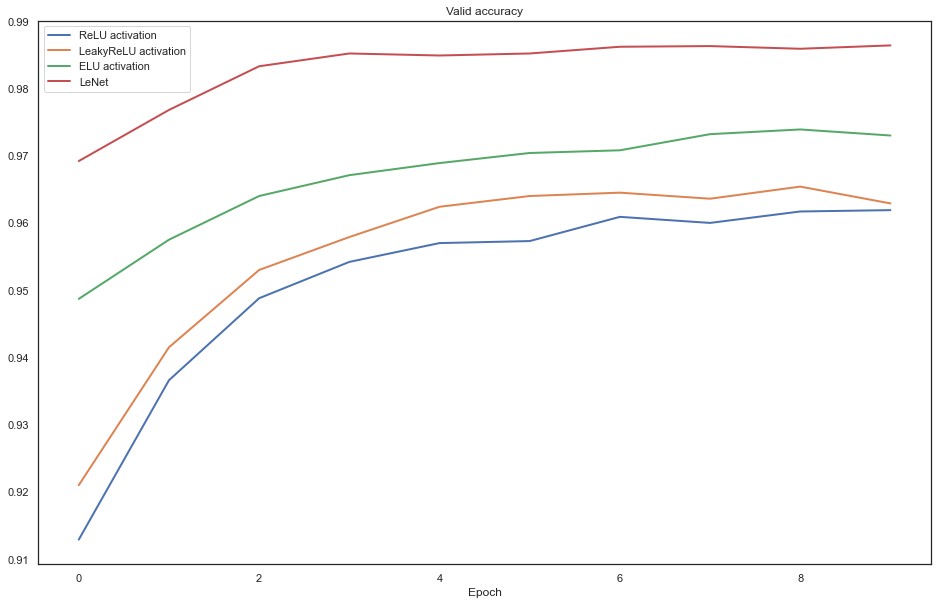

In [279]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**  Если оценивать по test, тогда 0.99